In [1]:
%env ALL_PROXY=http://localhost:20171
%env HTTP_PROXY=http://localhost:20171
%env HTTPS_PROXY=http://localhost:20171

env: ALL_PROXY=http://localhost:20171
env: HTTP_PROXY=http://localhost:20171
env: HTTPS_PROXY=http://localhost:20171


In [1]:
import torch
import math
from torch import nn

from PIL import Image
import torchvision.transforms as T
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import visualize_tools
import numpy as np
import os

Matplotlib is building the font cache; this may take a moment.


In [2]:
def interpolate_pos_encoding(x, w, h):
    N = x.shape[1] - 1
    dim = x.shape[-1]
    w0 = w / int(math.sqrt(N))
    h0 = h / int(math.sqrt(N))

    # Interpolate the position embeddings without changing the first row (class token)
    patch_pos_embed = nn.functional.interpolate(
        x[:, 1:]
        .reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim)
        .permute(0, 3, 1, 2),
        scale_factor=(w0, h0),
        mode="bicubic",
    )

    # assert int(w0) == patch_pos_embed.shape[-2]
    # assert int(h0) == patch_pos_embed.shape[-1]
    patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)

    # Concatenate the class token with the interpolated position embeddings
    return torch.cat((x[:, :1], patch_pos_embed), dim=1)


def get_downloaded_dino_vit_interpolated(modelname="dinov2_vits14", pretrained=False):
    model = torch.hub.load(
        "facebookresearch/dinov2", modelname, pretrained=pretrained
    )  #
    input_tensor = model.pos_embed
    tensor_corr_shape = interpolate_pos_encoding(input_tensor, 16, 16)
    pos_embed = nn.Parameter(torch.zeros(1, 257))
    pos_embed.data = tensor_corr_shape
    model.pos_embed = pos_embed
    return model


In [ ]:
local_weights_path = "/bd_byta6000i0/users/surgical_depth/DinoBloom/vitl_train/vitl_train/eval/training_99/teacher_checkpoint.pth"
# state_dict = torch.load(local_weights_path, map_location=torch.device("cuda"))
state_dict = torch.load(local_weights_path, map_location=torch.device("cpu"))

checkpoint1 = {}
for key, value in state_dict["teacher"].items():
    if "backbone." in key:
        checkpoint1[key.replace("backbone.", "")] = value


In [ ]:
local_weights_path = "/bd_byta6000i0/users/surgical_depth/DinoBloom/vitl_train/vitl_train/eval/training_19/teacher_checkpoint.pth"
# state_dict = torch.load(local_weights_path, map_location=torch.device("cuda"))
state_dict = torch.load(local_weights_path, map_location=torch.device("cpu"))

checkpoint2 = {}
for key, value in state_dict["teacher"].items():
    if "backbone." in key:
        checkpoint2[key.replace("backbone.", "")] = value

In [ ]:
similarity_scores = {}

for key in checkpoint1.keys():
    if key in checkpoint2:
        # 获取权重
        weight1 = checkpoint1[key]
        weight2 = checkpoint2[key]

        # 计算余弦相似度
        cos_sim = nn.functional.cosine_similarity(weight1.view(1, -1), weight2.view(1, -1)).item()

        # 计算欧氏距离
        euclidean_dist = torch.norm(weight1 - weight2).item()

        # 计算平均绝对误差 (MAE)
        mae = torch.mean(torch.abs(weight1 - weight2)).item()

        # 存储结果
        similarity_scores[key] = {
            'cosine_similarity': cos_sim,
            'euclidean_distance': euclidean_dist,
            'mae': mae
        }

# 打印结果
for key, scores in similarity_scores.items():
    print(f"Layer: {key}")
    print(f"  Cosine Similarity: {scores['cosine_similarity']}")
    print(f"  Euclidean Distance: {scores['euclidean_distance']}")
    print(f"  MAE: {scores['mae']}")
    print()

In [5]:
trained_model = get_downloaded_dino_vit_interpolated("dinov2_vitl14")
# 3. 将本地权重加载到模型中
# trained_model.load_state_dict(model_dict)

# 5. 设置模型为评估模式
trained_model.eval().to("cuda")

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/nfs/surgicaldinov2/.cache/torch/hub/main.zip
/home/nfs/surgicaldinov2/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/nfs/surgicaldinov2/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/nfs/surgicaldinov2/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [3]:
img = Image.open(
    "/bd_byta6000i0/users/dataset/MedicalImage/CholecSeg8k/processed/images/train/video37_00928frame_934_endo.png"
).convert("RGB")

In [ ]:
img.size

In [4]:
transform = T.Compose(
    [
        T.Resize((476, 854), T.InterpolationMode.BICUBIC),
        T.CenterCrop((476, 854)),
        T.ToTensor(),
        # T.Normalize(mean=[0.5], std=[0.5]),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
raw_img = transform(img)[:3].unsqueeze(0).to("cuda")

In [ ]:
features = trained_model.forward_features(raw_img)

In [ ]:
features.keys()

In [ ]:
features["x_norm_patchtokens"].shape

In [ ]:
pretrained_model = (
    torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14", pretrained=True)
    .eval()
    .to("cuda")
)
pre_features = pretrained_model.forward_features(raw_img)
pre_features = pre_features["x_norm_patchtokens"].reshape(1, 34, 61, 384)

In [ ]:
raw_features = features["x_norm_patchtokens"].reshape(1, 34, 61, 1024)

In [6]:
from visualize_tools import get_pca_map

In [ ]:
with torch.no_grad():
    pca = get_pca_map(raw_features, img_size=(476, 854))
    pre_pca = get_pca_map(pre_features, img_size=(476, 854))

In [ ]:
img

In [ ]:
pca.shape

In [ ]:
plt.imshow(pca)

In [ ]:
torch.save(trained_model, 'trained_model.pt')

In [ ]:
torch.save(pretrained_model, 'pretrained_model.pt')

In [ ]:
pca_imgs = []
with torch.no_grad():
    for i in range(499, 20499, 500):
        local_weights_path = (
            "/bd_byta6000i0/users/surgical_depth/DinoBloom/vitl_train/lr=2e-3_batchsize=32_local_crops/eval"
        )
        local_weights_path = os.path.join(
            local_weights_path, f"training_{i}", "teacher_checkpoint.pth"
        )
        state_dict = torch.load(local_weights_path, map_location=torch.device("cuda"))
        model_dict = {}
        for key, value in state_dict["teacher"].items():
            if "backbone." in key:
                model_dict[key.replace("backbone.", "")] = value
        trained_model.load_state_dict(model_dict)
        trained_model.eval().to("cuda")
        features = trained_model.forward_features(raw_img)
        raw_features = features["x_norm_patchtokens"].reshape(1, 34, 61, 1024)
        pca_img = get_pca_map(raw_features, img_size=(476, 854))
        pca_imgs.append(pca_img)

num_imgs = len(pca_imgs)
num_rows = (num_imgs + 6) // 8  # 每行5张，向上取整

# 创建一个大图
fig, axes = plt.subplots(num_rows, 8, figsize=(40, 3 * num_rows))

# 绘制每个图像
for i, ax in enumerate(axes.flatten()):
    if i < num_imgs:
        ax.imshow(pca_imgs[i])
        ax.set_title(f"Training {499 + i * 500}")
        ax.axis("off")
    else:
        ax.axis("off")  # 如果有空余的子图，关闭它们的轴

# 保存或显示大图
plt.tight_layout()
plt.savefig("pca_images.png")
plt.show()

In [ ]:
pca_imgs = []
with torch.no_grad():
    for i in range(499, 20499, 500):
        local_weights_path = (
            "/bd_byta6000i0/users/surgical_depth/DinoBloom/vitl_train/lr=2e-3_batchsize=32_local_crops/eval"
        )
        local_weights_path = os.path.join(
            local_weights_path, f"training_{i}", "student_checkpoint.pth"
        )
        state_dict = torch.load(local_weights_path, map_location=torch.device("cuda"))
        model_dict = {}
        for key, value in state_dict["student"].items():
            if "backbone." in key:
                model_dict[key.replace("backbone.", "")] = value
        trained_model.load_state_dict(model_dict)
        trained_model.eval().to("cuda")
        features = trained_model.forward_features(raw_img)
        raw_features = features["x_norm_patchtokens"].reshape(1, 34, 61, 1024)
        pca_img = get_pca_map(raw_features, img_size=(476, 854))
        pca_imgs.append(pca_img)

num_imgs = len(pca_imgs)
num_rows = (num_imgs + 6) // 8  # 每行5张，向上取整

# 创建一个大图
fig, axes = plt.subplots(num_rows, 8, figsize=(40, 3 * num_rows))

# 绘制每个图像
for i, ax in enumerate(axes.flatten()):
    if i < num_imgs:
        ax.imshow(pca_imgs[i])
        ax.set_title(f"Training {499 + i * 500}")
        ax.axis("off")
    else:
        ax.axis("off")  # 如果有空余的子图，关闭它们的轴

# 保存或显示大图
plt.tight_layout()
# plt.savefig("pca_images.png")
plt.show()

In [ ]:
# /bd_byta6000i0/users/surgical_depth/DinoBloom/vitl_train/depth_test/eval/

In [ ]:
pca_imgs = []
with torch.no_grad():
    for i in range(499, 20499, 500):
        local_weights_path = (
            "/bd_byta6000i0/users/surgical_depth/DinoBloom/vitl_train/depth_test/eval"
        )
        local_weights_path = os.path.join(
            local_weights_path, f"training_{i}", "student_checkpoint.pth"
        )
        state_dict = torch.load(local_weights_path, map_location=torch.device("cuda"))
        model_dict = {}
        for key, value in state_dict["student"].items():
            if "backbone." in key:
                model_dict[key.replace("backbone.", "")] = value
        trained_model.load_state_dict(model_dict)
        trained_model.eval().to("cuda")
        features = trained_model.forward_features(raw_img)
        raw_features = features["x_norm_patchtokens"].reshape(1, 34, 61, 1024)
        pca_img = get_pca_map(raw_features, img_size=(476, 854))
        pca_imgs.append(pca_img)

num_imgs = len(pca_imgs)
num_rows = (num_imgs + 6) // 8  # 每行5张，向上取整

# 创建一个大图
fig, axes = plt.subplots(num_rows, 8, figsize=(40, 3 * num_rows))

# 绘制每个图像
for i, ax in enumerate(axes.flatten()):
    if i < num_imgs:
        ax.imshow(pca_imgs[i])
        ax.set_title(f"Training {499 + i * 500}")
        ax.axis("off")
    else:
        ax.axis("off")  # 如果有空余的子图，关闭它们的轴

# 保存或显示大图
plt.tight_layout()
# plt.savefig("pca_images.png")
plt.show()

In [10]:
from tqdm import tqdm

100%|██████████| 20/20 [16:15<00:00, 48.78s/it]


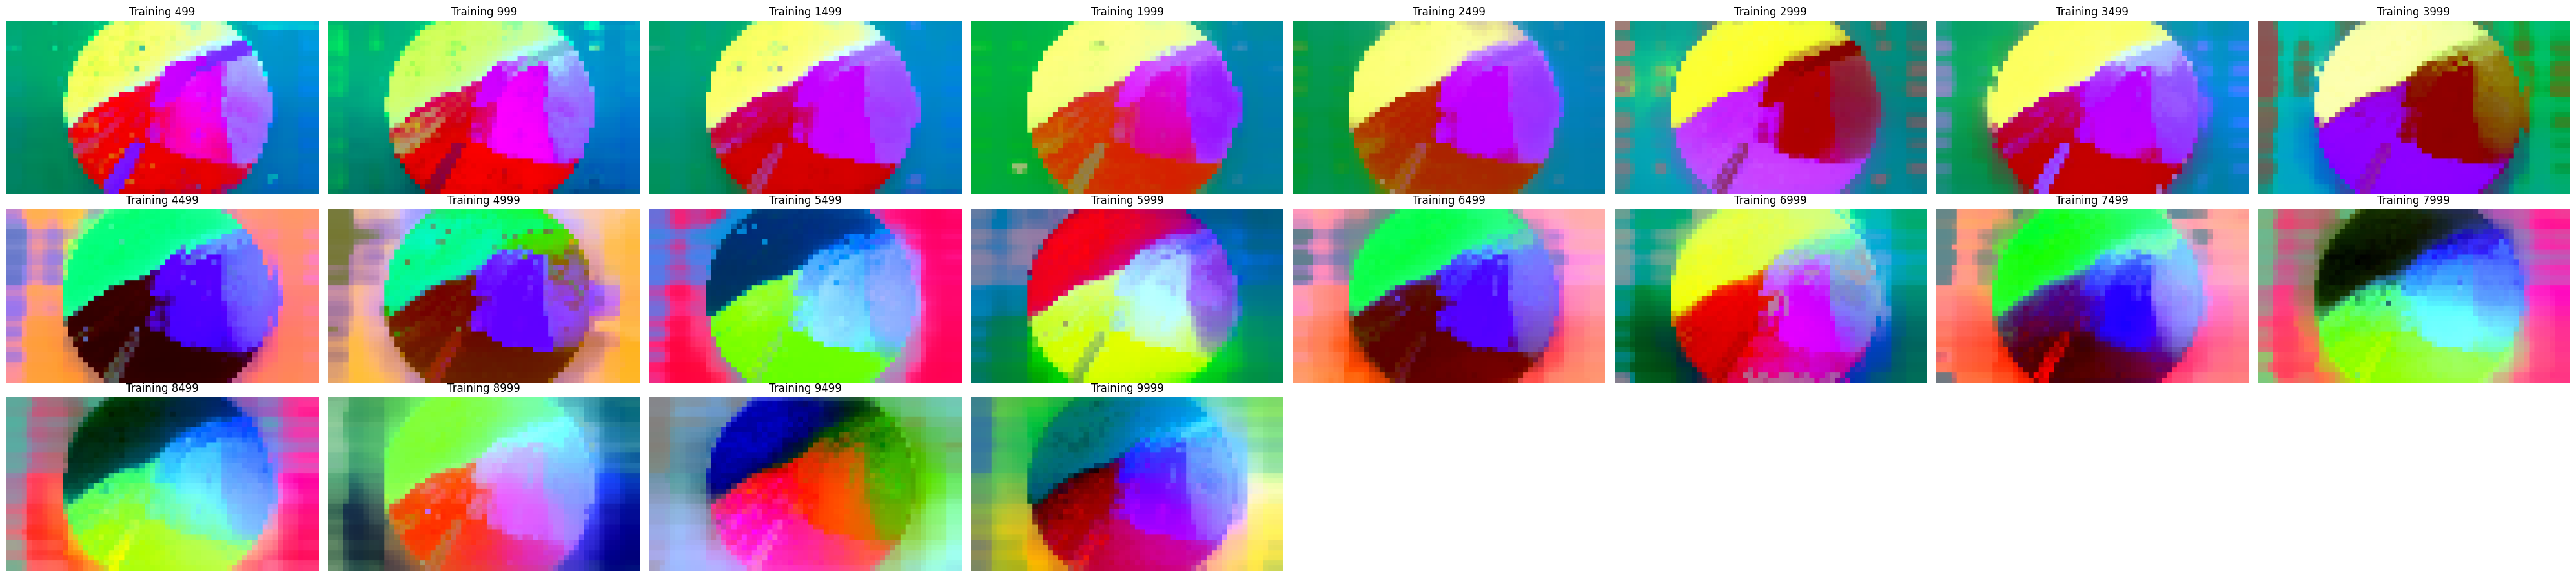

In [11]:
pca_imgs = []
with torch.no_grad():
    for i in tqdm(range(499, 10499, 500)):
        local_weights_path = (
            "/bd_byta6000i0/users/surgicaldinov2/kyyang/surgical_dinov2/vitl_train/only_seg/eval"
        )
        local_weights_path = os.path.join(
            local_weights_path, f"training_{i}", "student_checkpoint.pth"
        )
        state_dict = torch.load(local_weights_path, map_location=torch.device("cuda"))
        model_dict = {}
        for key, value in state_dict["student"].items():
            if "backbone." in key:
                model_dict[key.replace("backbone.", "")] = value
        trained_model.load_state_dict(model_dict)
        trained_model.eval().to("cuda")
        features = trained_model.forward_features(raw_img)
        raw_features = features["x_norm_patchtokens"].reshape(1, 34, 61, 1024)
        pca_img = get_pca_map(raw_features, img_size=(476, 854))
        pca_imgs.append(pca_img)

num_imgs = len(pca_imgs)
num_rows = (num_imgs + 6) // 8  # 每行5张，向上取整

# 创建一个大图
fig, axes = plt.subplots(num_rows, 8, figsize=(40, 3 * num_rows))

# 绘制每个图像
for i, ax in enumerate(axes.flatten()):
    if i < num_imgs:
        ax.imshow(pca_imgs[i])
        ax.set_title(f"Training {499 + i * 500}")
        ax.axis("off")
    else:
        ax.axis("off")  # 如果有空余的子图，关闭它们的轴

# 保存或显示大图
plt.tight_layout()
# plt.savefig("pca_images.png")
plt.show()

100%|██████████| 4/4 [01:24<00:00, 21.13s/it]


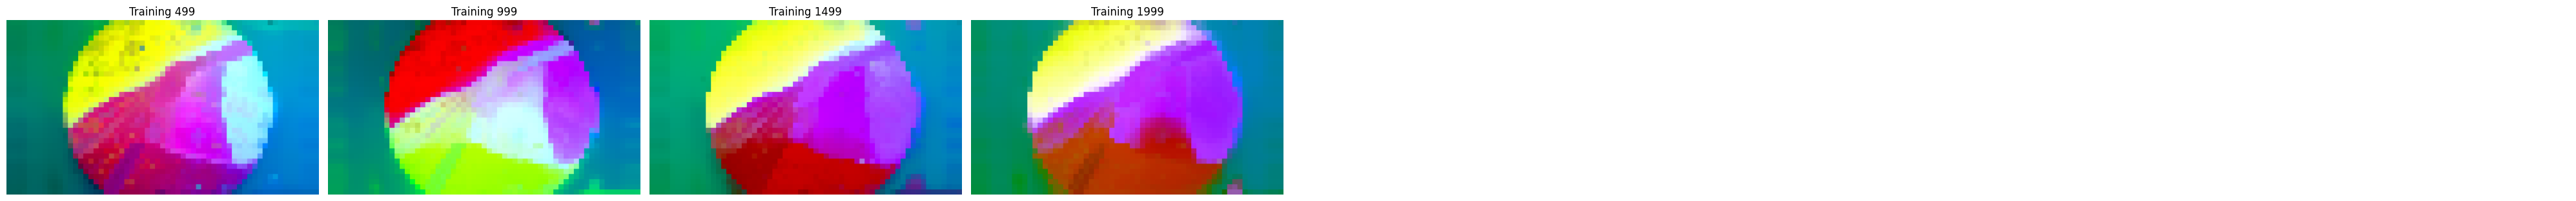

In [14]:
pca_imgs = []
with torch.no_grad():
    for i in tqdm(range(499, 2499, 500)):
        local_weights_path = (
            "/bd_byta6000i0/users/surgicaldinov2/kyyang/surgical_dinov2/vitl_train/seg_depth/eval"
        )
        local_weights_path = os.path.join(
            local_weights_path, f"training_{i}", "student_checkpoint.pth"
        )
        state_dict = torch.load(local_weights_path, map_location=torch.device("cuda"))
        model_dict = {}
        for key, value in state_dict["student"].items():
            if "backbone." in key:
                model_dict[key.replace("backbone.", "")] = value
        trained_model.load_state_dict(model_dict)
        trained_model.eval().to("cuda")
        features = trained_model.forward_features(raw_img)
        raw_features = features["x_norm_patchtokens"].reshape(1, 34, 61, 1024)
        pca_img = get_pca_map(raw_features, img_size=(476, 854))
        pca_imgs.append(pca_img)

num_imgs = len(pca_imgs)
num_rows = (num_imgs + 6) // 8  # 每行5张，向上取整

# 创建一个大图
fig, axes = plt.subplots(num_rows, 8, figsize=(40, 3 * num_rows))

# 绘制每个图像
for i, ax in enumerate(axes.flatten()):
    if i < num_imgs:
        ax.imshow(pca_imgs[i])
        ax.set_title(f"Training {499 + i * 500}")
        ax.axis("off")
    else:
        ax.axis("off")  # 如果有空余的子图，关闭它们的轴

# 保存或显示大图
plt.tight_layout()
plt.savefig("pca_images_seg_depth.png")
plt.show()

100%|██████████| 4/4 [03:19<00:00, 49.79s/it]


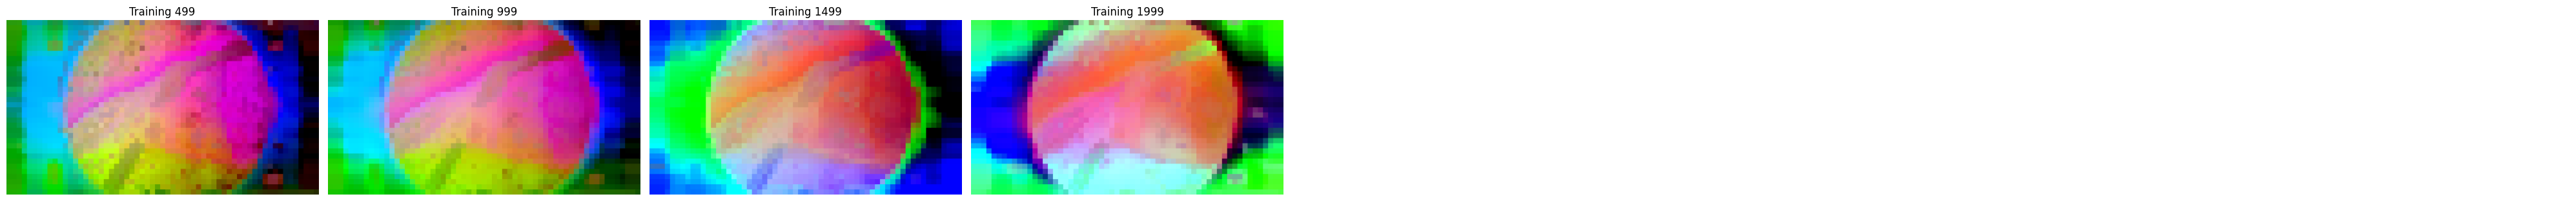

In [15]:
pca_imgs = []
with torch.no_grad():
    for i in tqdm(range(499, 2499, 500)):
        local_weights_path = (
            "/bd_byta6000i0/users/surgicaldinov2/kyyang/surgical_dinov2/vitl_train/only_depth/eval"
        )
        local_weights_path = os.path.join(
            local_weights_path, f"training_{i}", "student_checkpoint.pth"
        )
        state_dict = torch.load(local_weights_path, map_location=torch.device("cuda"))
        model_dict = {}
        for key, value in state_dict["student"].items():
            if "backbone." in key:
                model_dict[key.replace("backbone.", "")] = value
        trained_model.load_state_dict(model_dict)
        trained_model.eval().to("cuda")
        features = trained_model.forward_features(raw_img)
        raw_features = features["x_norm_patchtokens"].reshape(1, 34, 61, 1024)
        pca_img = get_pca_map(raw_features, img_size=(476, 854))
        pca_imgs.append(pca_img)

num_imgs = len(pca_imgs)
num_rows = (num_imgs + 6) // 8  # 每行5张，向上取整

# 创建一个大图
fig, axes = plt.subplots(num_rows, 8, figsize=(40, 3 * num_rows))

# 绘制每个图像
for i, ax in enumerate(axes.flatten()):
    if i < num_imgs:
        ax.imshow(pca_imgs[i])
        ax.set_title(f"Training {499 + i * 500}")
        ax.axis("off")
    else:
        ax.axis("off")  # 如果有空余的子图，关闭它们的轴

# 保存或显示大图
plt.tight_layout()
plt.savefig("pca_images_depth.png")
plt.show()

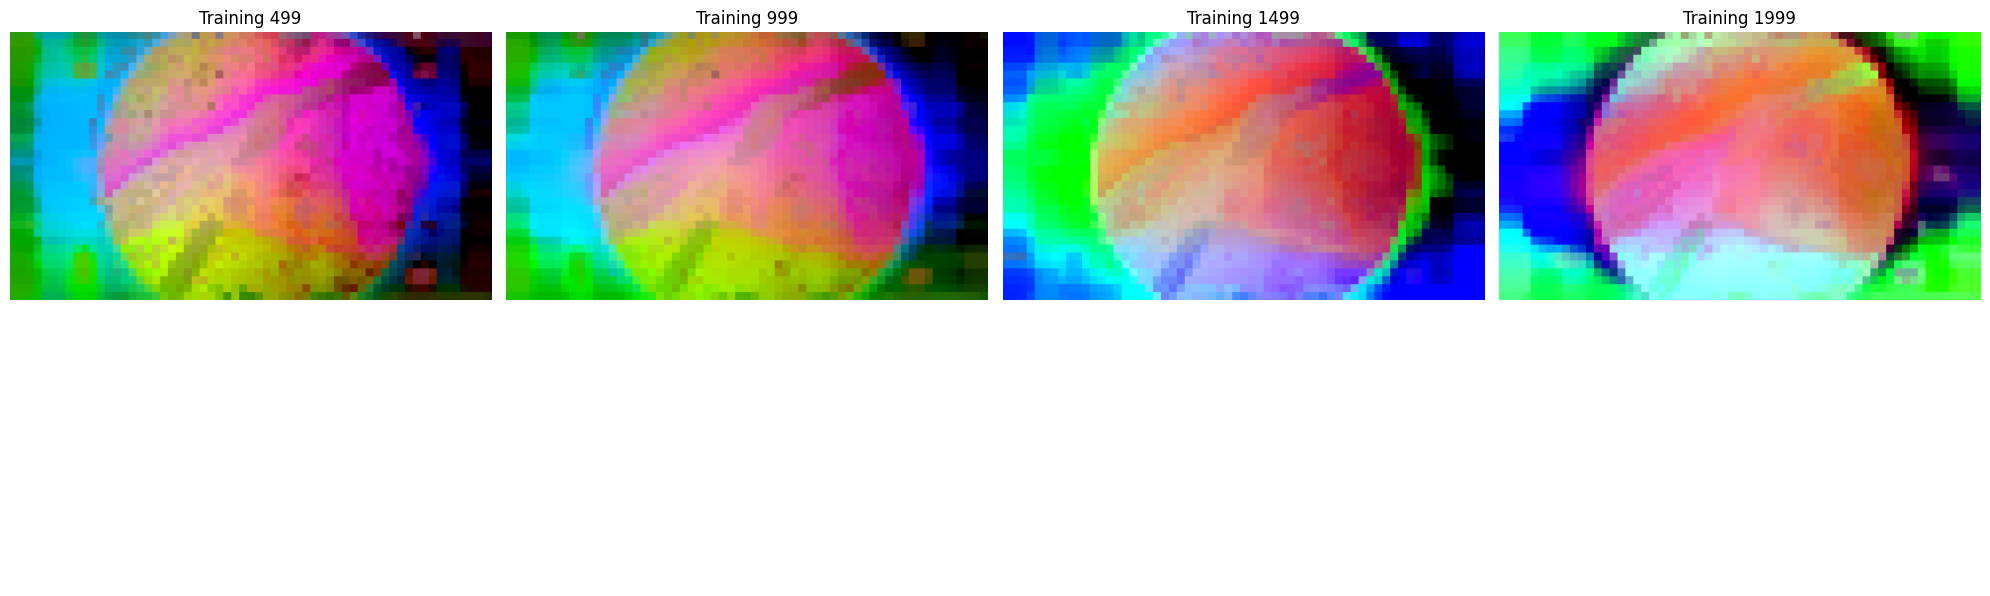

In [18]:

num_imgs = len(pca_imgs)
num_rows = (num_imgs + 6) // 4  # 每行5张，向上取整

# 创建一个大图
fig, axes = plt.subplots(num_rows, 4, figsize=(20, 3 * num_rows))

# 绘制每个图像
for i, ax in enumerate(axes.flatten()):
    if i < num_imgs:
        ax.imshow(pca_imgs[i])
        ax.set_title(f"Training {499 + i * 500}")
        ax.axis("off")
    else:
        ax.axis("off")  # 如果有空余的子图，关闭它们的轴

# 保存或显示大图
plt.tight_layout()
plt.savefig("pca_images_1.png")
plt.show()

In [ ]:
plt.imshow(raw_img.cpu().squeeze(0).permute(1, 2, 0).numpy())

In [ ]:
torch.save()